In [1]:
#using DifferentialEquations



In [1]:
using Plots

In [2]:
### Object declaration
mutable struct Particle
    # Position
    x::Float64
    y::Float64
    # Velocity
    v_x::Float64
    v_y::Float64
    # Other properties: mass, charge
    m::Float64
    q::Float64
    
    # Constructors
    Particle(x, y, v_x, v_y, m, q) = new(x, y, v_x, v_y, m, q)
    Particle(x, y, v_x, v_y) = new(x, y, v_x, v_y, 1, 0)
    
end

function phase_trajectories(p::Particle)
    return (p.x, p.y, p.v_x, p.v_y)
end
#particles = [Particle(i, 2*i, i, i, i, i) for i in 1:3]

phase_trajectories (generic function with 1 method)

In [18]:
K = -10
x = 2.
y = 1.5
#p1 = Particle(0.0, 0.0, 0.0, 1.0)
#p2 = Particle(1, 0.8, 0.5, 0.5)
#particles = [p1, p2]

t_span = (0.0,3.0)
#N_steps = 1000


#function foo(p::Particle)
#    [p.v_x, p.v_y,  K / p.m * (p.x - x) / ((p.x - x)^2 + (p.y - y)^2)^3,K / p.m * (p.y - y) / ((p.x - x)^2 + (p.y - y)^2)^3]
#end
#function foo(u,p,t) 
#    return  [u[3], 
#            u[4],  
#            K * (u[1] - u[5]) / sqrt((u[1] - u[5])^2 + (u[2] - u[6])^2)^3,
#            K * (u[2] - u[6]) / sqrt((u[1] - u[5])^2 + (u[2] - u[6])^2)^3,
#            u[7],
#            u[8],
#            K * (u[5] - u[1]) / sqrt((u[1] - u[5])^2 + (u[2] - u[6])^2)^3,
#            K * (u[6] - u[2]) / sqrt((u[1] - u[5])^2 + (u[2] - u[6])^2)^3]
#            
#end

#function RK4(u, f::Function, dt)
#    k1 = f()
#end

function Forces(p::Particle, dt)
    x = 0.0
    y = 0.0
    (a1, a2) =  [p.x-x, p.y-y] * K/(sqrt((p.x-x)^2 + (p.y-y)^2)^3)
    (p.v_x, p.v_y) = [p.v_x, p.v_y] + dt * [a1, a2]
    (p.x, p.y) = [p.x, p.y] + [p.v_x, p.v_y] + dt * [a1, a2]/2) * dt^2
end

function trajectory(p::Particle, t_range::Tuple, N)
    dt = (t_range[2]-t_range[1])/N
    trajectory = zeros(N+1, 4)
    trajectory[1,:] = [p.x, p.y, p.v_x, p.v_y]
    
    for i in 2:(N+1)
        Forces(p, dt)
        trajectory[i,:] = [p.x, p.y, p.v_x, p.v_y]
    end
    
    return trajectory
end

#phase_trajectories(p1)

#u[:,1] = [p.x,p.y,p.v_x,p.v_y]
#u_0 = Float64[i for j in particles for i in phase_trajectories(j)]
#prob = ODEProblem(foo, u_0, t_span)

#sol = solve(prob)
#plot(sol)

#foo([1,2,1,33], 0, 0)

trajectory (generic function with 1 method)

In [107]:
sol = trajectory(Particle(1,1,1,0,1,0), (0,1), 100)

LoadError: UndefVarError: trajectory not defined

In [224]:
K = -4

function Forces(particles, i, dt)
    position = zeros(4)
    p = particles[i]
    position[3:4] .= [p.v_x, p.v_y]
    position[1:2] .= [p.x, p.y]
    for (index, p_other) in enumerate(particles) 
        if(index != i)
            (a1, a2) = [p.x-p_other.x, p.y-p_other.y] * K/(sqrt((p.x-p_other.x)^2 + (p.y-p_other.y)^2)^3)
            position[3:4] .= position[3:4] + dt * [a1, a2]
            position[1:2] .= position[1:2] + [p.v_x, p.v_y]*dt + [a1, a2]/2 * dt^2
        end
    end
    return position
end

function trajectories(particles, t_range::Tuple, N)
    dt = (t_range[2] - t_range[1])/N
    trajectories = zeros(N + 1, 4 * length(particles))
    for (index, p) in enumerate(particles)
        trajectories[1, (4*index-3):(4*index)] .= [p.x, p.y, p.v_x, p.v_y]
    end

    for i in 2:(N + 1)
        for (index, p) in enumerate(particles)
            trajectories[i,(4*index-3):(4*index)] .= Forces(particles, index, dt)

        end
        
        for (index, p) in enumerate(particles)
            (p.x, p.y, p.v_x, p.v_y) = trajectories[i, (4*index-3):(4*index)]
        end
    end
    
    return trajectories
end

trajectories (generic function with 1 method)

In [225]:
p1 = Particle(1,1,0,1)
p2 = Particle(0,0.5,0,0)
p3 = Particle(-1,-0.5,-1,2)
p4 = Particle(1,-0.5,1,0.8)
p5 = Particle(2,1,-1,-1)
particles = [p1, p2, p3, p4,p5]


5-element Array{Particle,1}:
 Particle(1.0, 1.0, 0.0, 1.0, 1.0, 0.0)
 Particle(0.0, 0.5, 0.0, 0.0, 1.0, 0.0)
 Particle(-1.0, -0.5, -1.0, 2.0, 1.0, 0.0)
 Particle(1.0, -0.5, 1.0, 0.8, 1.0, 0.0)
 Particle(2.0, 1.0, -1.0, -1.0, 1.0, 0.0)

In [226]:
sol = trajectories(particles, (0,10), 1000)

1001×20 Array{Float64,2}:
   1.0         1.0       0.0         …   1.0       -1.0       -1.0
   1.00003     1.03982   0.00625833      0.959929  -1.05914   -1.01411
   1.00034     1.07819   0.0172782       0.919306  -1.12258   -1.02598
   1.0011      1.11495   0.032516        0.87822   -1.19008   -1.03521
   1.0025      1.14992   0.0512009       0.83678   -1.26121   -1.04158
   1.00465     1.18291   0.0723256   …   0.795099  -1.33532   -1.04517
   1.00766     1.21369   0.0946717       0.753285  -1.41159   -1.04657
   1.01155     1.24203   0.116874        0.711419  -1.48905   -1.04709
   1.01633     1.26767   0.137519        0.669526  -1.56664   -1.04908
   1.02192     1.29041   0.155278        0.627526  -1.64307   -1.05638
   1.0282      1.31004   0.169026    …   0.585178  -1.71649   -1.07498
   1.03501     1.3264    0.177968        0.541984  -1.78302   -1.11398
   1.04215     1.33939   0.181712        0.497064  -1.83314   -1.18611
   ⋮                                 ⋱                 

In [227]:
p1

Particle(-38.687672341298246, -169.0981524029412, -1.0740344952571208, -4.453275034367378, 1.0, 0.0)

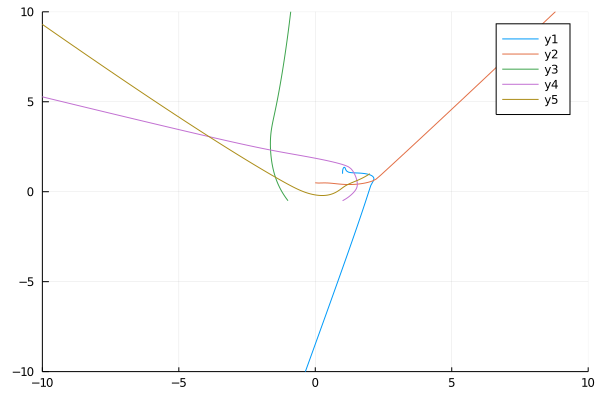

In [228]:

plot(sol[:,1], sol[:,2], lims=(-10,10))
for (index, p) in enumerate(particles)
    if index == 1
        continue
    end
    plot!(sol[:,(4*index-3)], sol[:,(4*index-2)])
end
current()
